In [6]:
%load_ext autoreload
%autoreload 2
%cd ~/dev/ROADMAP/
%matplotlib nbagg

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

import random

import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Compose, Resize, Normalize, CenterCrop
from PIL import Image
from tqdm.notebook import tqdm

from roadmap.datasets import SOPDataset
from roadmap.models import RetrievalNet
from roadmap.engine import get_knn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/users/r/ramzie/dev/NDCG


In [3]:
sop_transform = Compose(
    (Resize((256, 256)),
     CenterCrop(224),
     ToTensor(),
     Normalize(
         mean=[0.485, 0.456, 0.406],
         std=[0.229, 0.224, 0.225])
    )
)

sop_dts = SOPDataset(
    "/local/DEEPLEARNING/image_retrieval/Stanford_Online_Products/",
    'test',
    transform=sop_transform,
)

sop_loader = DataLoader(sop_dts, batch_size=256, num_workers=16, pin_memory=True)

In [4]:
net = RetrievalNet(
    'resnet50',
    with_autocast=True,
)
CKPT = 'PATH/TO/YOUR/CHECKPOINT'
state = torch.load(
    CKPT,
    map_location='cpu'
)
net.load_state_dict(state["net_state"])
_ = net.eval()
_ = net.cuda()
_ = net.requires_grad_(False)

In [7]:
def compute_embeddings(
    net,
    loader,
    convert_to_cuda=False,
    select_embedding=None,
    with_paths=False,
):
    features = []

    mode = net.training
    net.eval()
    lib.LOGGER.info("Computing embeddings")
    for i, batch in enumerate(tqdm(loader, disable=os.getenv("TQDM_DISABLE"))):
        with torch.no_grad():
            X = net(batch["image"].cuda())

        features.append(X)

    features = torch.cat(features)
    labels = torch.from_numpy(loader.dataset.labels).to('cuda' if convert_to_cuda else 'cpu')

    net.train(mode)
    if with_paths:
        return features, labels, loader.dataset.paths
    else:
        return features, labels



features, labels = compute_embeddings(
    net,
    sop_loader,
)

  0%|          | 0/237 [00:00<?, ?it/s]

In [8]:
def reader(
    path,
    resize=(256, 256),
    crop=224,
):
    img = Image.open(path)
    if resize:
        img = Resize(resize)(img)
    if crop:
        img = CenterCrop(crop)(img)
    return img


COLOR_COMPARISON = {
    1: {0: "crimson", 1: "chartreuse"}
}


def visualise_from_paths(
    PATHS,
    LABELS=None,
    figsize=(10, 5),
    show=True,
    crop=600,
    resize=600,
    linewidth=4,
    savefig=None,
    compress=True,
):
    if not isinstance(PATHS[0], (list, tuple)):
        PATHS = [PATHS]
        if LABELS is not None:
            assert not isinstance(LABELS[0], (list, tuple))
            LABELS = [LABELS]

    NUM_ROWS = len(PATHS)
    NUM_PLOTS = len(PATHS[0])
    fig = plt.figure(figsize=figsize)
    plot_number = 1

    for i, paths in enumerate(PATHS):
        labels = None
        if LABELS is not None:
            labels = LABELS[i]
        query_path = paths[0]
        paths = paths[1:]

        colors = None
        if labels is not None:
            query_label = labels[0]
            labels = labels[1:]
            if isinstance(query_label, list):
                level = len(query_label)
                colors = [COLOR_COMPARISON[level][sum([int(y_gt == y_hat) for y_gt, y_hat in zip(query_label, x)])] for x in labels]
            else:
                level = 1
                colors = [COLOR_COMPARISON[level][1] if x == query_label else COLOR_COMPARISON[level][0] for x in labels]

        ax = plt.subplot(NUM_ROWS, NUM_PLOTS, plot_number)
        plot_number += 1

        if linewidth is not None:
            rect = patches.Rectangle((0, 0), crop, crop, linewidth=linewidth, edgecolor='m', facecolor='none')
            ax.add_patch(rect)

        plt.imshow(reader(query_path, resize=resize, crop=crop))
        plt.xticks([])
        plt.yticks([])

        for i, pth in enumerate(paths):
            ax = plt.subplot(NUM_ROWS, NUM_PLOTS, plot_number)
            plot_number += 1

            if (colors is not None) and (linewidth is not None):
                clr = colors[i]
                rect = patches.Rectangle((0, 0), crop, crop, linewidth=linewidth, edgecolor=clr, facecolor='none')
                ax.add_patch(rect)

            plt.imshow(reader(pth, resize=resize, crop=crop))
            plt.xticks([])
            plt.yticks([])

    if savefig is not None:
        plt.savefig(
            lib.expand_path(savefig),
            transparent=True,
            bbox_inches='tight',
            pad_inches=0,
        )

    if show:
        plt.show()

    return fig

[2081]


<IPython.core.display.Javascript object>


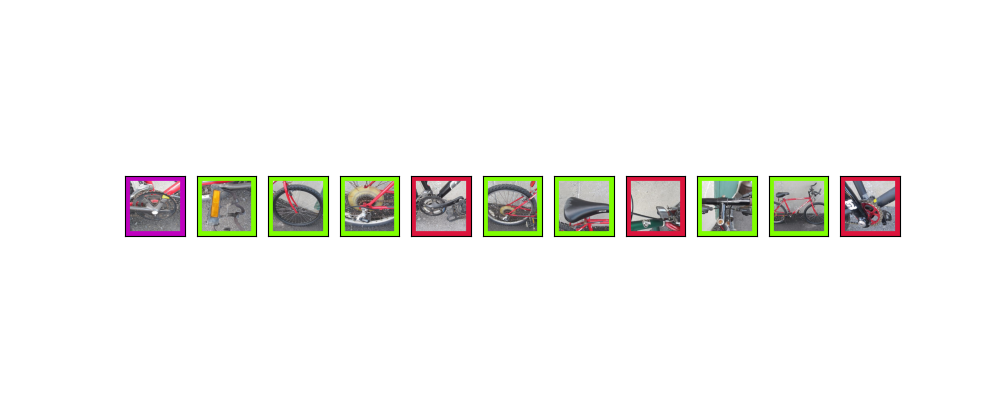

In [21]:
selected = random.sample(range(len(sop_dts)), 1)
print(selected)

number = 10

indices, distances = get_knn(
    features, features[selected],
    number,
    embeddings_come_from_same_source=True,
    with_faiss=False,
)

PATHS = []
LABELS = []
for i, idxs in enumerate(indices):
    paths = [sop_dts.paths[selected[i]]] + [sop_dts.paths[x] for x in idxs]
    PATHS.append(paths)
    
    labels = [sop_dts.labels[selected[i]]] + [sop_dts.labels[x] for x in idxs]
    LABELS.append(labels)
    
    
fig = visualise_from_paths(
    PATHS,
    LABELS,
    figsize=(10, 4.1),
    linewidth=7
)